In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold,StratifiedKFold

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [43]:
def build_network():
    os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\based_model\原数据\K_CNN_OH')
    cnn = load_model('dataoh.h5')
    cnn.trainable = True #固定所有预训练模型层的参数
    base_model = Model(inputs=cnn.layers[0].input,outputs=cnn.layers[8].output)
    base_model.summary()
    base_model.trainable = True
    for layer in base_model.layers[:6]:
        layer.trainable = False
    Dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)
    global_average_layer = tf.keras.layers.GlobalAveragePooling1D()
    prediction_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    model1 = tf.keras.Sequential([
        base_model,
        #layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        Dense,
        layers.Dropout(0.5),
        global_average_layer,
        prediction_layer
    ])
    base_learning_rate = 0.0005
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #model1.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    #model1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
    model1.summary()
    return model1

In [44]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [45]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [46]:
batch_size=256

In [47]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\不自然数据\1正2345负')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [48]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [49]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [50]:
prediction_result_cv = []
prediction_result_ind = []

In [51]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2')

In [52]:
out = os.getcwd() + '\\'

In [53]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    model1 = build_network()
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model1.fit(train_db, epochs=300, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = model1.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = model1.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0  

8/8 - 0s - loss: 0.6388 - accuracy: 0.6352 - val_loss: 0.6585 - val_accuracy: 0.6044

Epoch 00021: val_loss improved from 0.65881 to 0.65846, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_0.h5
Epoch 22/300
8/8 - 0s - loss: 0.6260 - accuracy: 0.6495 - val_loss: 0.6596 - val_accuracy: 0.6178

Epoch 00022: val_loss did not improve from 0.65846
Epoch 23/300
8/8 - 0s - loss: 0.6326 - accuracy: 0.6461 - val_loss: 0.6579 - val_accuracy: 0.6178

Epoch 00023: val_loss improved from 0.65846 to 0.65788, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_0.h5
Epoch 24/300
8/8 - 0s - loss: 0.6323 - accuracy: 0.6461 - val_loss: 0.6556 - val_accuracy: 0.6089

Epoch 00024: val_loss improved from 0.65788 to 0.65563, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_0.h5

8/8 - 0s - loss: 0.5765 - accuracy: 0.6990 - val_loss: 0.6465 - val_accuracy: 0.6356

Epoch 00060: val_loss did not improve from 0.64563
Epoch 61/300
8/8 - 0s - loss: 0.5713 - accuracy: 0.7029 - val_loss: 0.6469 - val_accuracy: 0.6311

Epoch 00061: val_loss did not improve from 0.64563
Epoch 62/300
8/8 - 0s - loss: 0.5729 - accuracy: 0.7103 - val_loss: 0.6483 - val_accuracy: 0.6444

Epoch 00062: val_loss did not improve from 0.64563
Epoch 63/300
8/8 - 0s - loss: 0.5698 - accuracy: 0.7153 - val_loss: 0.6501 - val_accuracy: 0.6311

Epoch 00063: val_loss did not improve from 0.64563
Epoch 64/300
8/8 - 0s - loss: 0.5671 - accuracy: 0.7054 - val_loss: 0.6477 - val_accuracy: 0.6356

Epoch 00064: val_loss did not improve from 0.64563
Epoch 65/300
8/8 - 0s - loss: 0.5669 - accuracy: 0.7014 - val_loss: 0.6466 - val_accuracy: 0.6400

Epoch 00065: val_loss did not improve from 0.64563
Epoch 66/300
8/8 - 0s - loss: 0.5721 - accuracy: 0.7000 - val_loss: 0.6474 - val_accuracy: 0.6400

Epoch 00066: v

8/8 - 0s - loss: 0.4924 - accuracy: 0.7637 - val_loss: 0.6574 - val_accuracy: 0.6711

Epoch 00113: val_loss did not improve from 0.64420
Epoch 114/300
8/8 - 0s - loss: 0.5109 - accuracy: 0.7469 - val_loss: 0.6584 - val_accuracy: 0.6622

Epoch 00114: val_loss did not improve from 0.64420
Epoch 115/300
8/8 - 0s - loss: 0.4905 - accuracy: 0.7746 - val_loss: 0.6562 - val_accuracy: 0.6578

Epoch 00115: val_loss did not improve from 0.64420
Epoch 116/300
8/8 - 0s - loss: 0.5009 - accuracy: 0.7573 - val_loss: 0.6572 - val_accuracy: 0.6533

Epoch 00116: val_loss did not improve from 0.64420
Epoch 117/300
8/8 - 0s - loss: 0.4866 - accuracy: 0.7598 - val_loss: 0.6558 - val_accuracy: 0.6622

Epoch 00117: val_loss did not improve from 0.64420
Epoch 118/300
8/8 - 0s - loss: 0.4946 - accuracy: 0.7523 - val_loss: 0.6689 - val_accuracy: 0.5911

Epoch 00118: val_loss did not improve from 0.64420
Epoch 119/300
8/8 - 0s - loss: 0.4863 - accuracy: 0.7632 - val_loss: 0.6594 - val_accuracy: 0.6489

Epoch 00


Epoch 00009: val_loss improved from 0.66794 to 0.66506, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_1.h5
Epoch 10/300
8/8 - 0s - loss: 0.6544 - accuracy: 0.6194 - val_loss: 0.6628 - val_accuracy: 0.6222

Epoch 00010: val_loss improved from 0.66506 to 0.66276, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_1.h5
Epoch 11/300
8/8 - 0s - loss: 0.6502 - accuracy: 0.6283 - val_loss: 0.6608 - val_accuracy: 0.6222

Epoch 00011: val_loss improved from 0.66276 to 0.66081, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_1.h5
Epoch 12/300
8/8 - 0s - loss: 0.6478 - accuracy: 0.6218 - val_loss: 0.6590 - val_accuracy: 0.6311

Epoch 00012: val_loss improved from 0.66081 to 0.65900, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\t


Epoch 00041: val_loss did not improve from 0.62933
Epoch 42/300
8/8 - 0s - loss: 0.6033 - accuracy: 0.6698 - val_loss: 0.6304 - val_accuracy: 0.6489

Epoch 00042: val_loss did not improve from 0.62933
Epoch 43/300
8/8 - 0s - loss: 0.6071 - accuracy: 0.6693 - val_loss: 0.6320 - val_accuracy: 0.6489

Epoch 00043: val_loss did not improve from 0.62933
Epoch 44/300
8/8 - 0s - loss: 0.6022 - accuracy: 0.6787 - val_loss: 0.6283 - val_accuracy: 0.6933

Epoch 00044: val_loss improved from 0.62933 to 0.62834, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_1.h5
Epoch 45/300
8/8 - 0s - loss: 0.6034 - accuracy: 0.6747 - val_loss: 0.6283 - val_accuracy: 0.6711

Epoch 00045: val_loss improved from 0.62834 to 0.62825, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_1.h5
Epoch 46/300
8/8 - 0s - loss: 0.5883 - accuracy: 0.6915 - val_loss: 0.62


Epoch 00084: val_loss did not improve from 0.60873
Epoch 85/300
8/8 - 0s - loss: 0.5407 - accuracy: 0.7261 - val_loss: 0.6118 - val_accuracy: 0.6800

Epoch 00085: val_loss did not improve from 0.60873
Epoch 86/300
8/8 - 0s - loss: 0.5393 - accuracy: 0.7375 - val_loss: 0.6139 - val_accuracy: 0.6844

Epoch 00086: val_loss did not improve from 0.60873
Epoch 87/300
8/8 - 0s - loss: 0.5464 - accuracy: 0.7222 - val_loss: 0.6115 - val_accuracy: 0.6711

Epoch 00087: val_loss did not improve from 0.60873
Epoch 88/300
8/8 - 0s - loss: 0.5209 - accuracy: 0.7484 - val_loss: 0.6076 - val_accuracy: 0.6889

Epoch 00088: val_loss improved from 0.60873 to 0.60755, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_1.h5
Epoch 89/300
8/8 - 0s - loss: 0.5398 - accuracy: 0.7187 - val_loss: 0.6122 - val_accuracy: 0.6667

Epoch 00089: val_loss did not improve from 0.60755
Epoch 90/300
8/8 - 0s - loss: 0.5165 - accuracy: 0.7484 - va


Epoch 00137: val_loss did not improve from 0.60370
Epoch 138/300
8/8 - 0s - loss: 0.4551 - accuracy: 0.7810 - val_loss: 0.6224 - val_accuracy: 0.6622

Epoch 00138: val_loss did not improve from 0.60370
Epoch 139/300
8/8 - 0s - loss: 0.4452 - accuracy: 0.7874 - val_loss: 0.6329 - val_accuracy: 0.6533

Epoch 00139: val_loss did not improve from 0.60370
Epoch 140/300
8/8 - 0s - loss: 0.4467 - accuracy: 0.7830 - val_loss: 0.6267 - val_accuracy: 0.6667

Epoch 00140: val_loss did not improve from 0.60370
Epoch 141/300
8/8 - 0s - loss: 0.4463 - accuracy: 0.7949 - val_loss: 0.6225 - val_accuracy: 0.6756

Epoch 00141: val_loss did not improve from 0.60370
Epoch 142/300
8/8 - 0s - loss: 0.4671 - accuracy: 0.7706 - val_loss: 0.6332 - val_accuracy: 0.6311

Epoch 00142: val_loss did not improve from 0.60370
Epoch 143/300
8/8 - 0s - loss: 0.4626 - accuracy: 0.7815 - val_loss: 0.6227 - val_accuracy: 0.6622

Epoch 00143: val_loss did not improve from 0.60370
Epoch 144/300
8/8 - 0s - loss: 0.4433 - ac


Epoch 00011: val_loss improved from 0.66721 to 0.66558, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_2.h5
Epoch 12/300
8/8 - 0s - loss: 0.6558 - accuracy: 0.6100 - val_loss: 0.6654 - val_accuracy: 0.5822

Epoch 00012: val_loss improved from 0.66558 to 0.66540, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_2.h5
Epoch 13/300
8/8 - 0s - loss: 0.6503 - accuracy: 0.6204 - val_loss: 0.6650 - val_accuracy: 0.5911

Epoch 00013: val_loss improved from 0.66540 to 0.66500, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_2.h5
Epoch 14/300
8/8 - 0s - loss: 0.6440 - accuracy: 0.6258 - val_loss: 0.6639 - val_accuracy: 0.5600

Epoch 00014: val_loss improved from 0.66500 to 0.66386, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\t

8/8 - 0s - loss: 0.5938 - accuracy: 0.6782 - val_loss: 0.6484 - val_accuracy: 0.5956

Epoch 00047: val_loss did not improve from 0.64743
Epoch 48/300
8/8 - 0s - loss: 0.6021 - accuracy: 0.6856 - val_loss: 0.6475 - val_accuracy: 0.6222

Epoch 00048: val_loss did not improve from 0.64743
Epoch 49/300
8/8 - 0s - loss: 0.5949 - accuracy: 0.6856 - val_loss: 0.6462 - val_accuracy: 0.6267

Epoch 00049: val_loss improved from 0.64743 to 0.64621, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_2.h5
Epoch 50/300
8/8 - 0s - loss: 0.5913 - accuracy: 0.6930 - val_loss: 0.6475 - val_accuracy: 0.6311

Epoch 00050: val_loss did not improve from 0.64621
Epoch 51/300
8/8 - 0s - loss: 0.5938 - accuracy: 0.6812 - val_loss: 0.6452 - val_accuracy: 0.6222

Epoch 00051: val_loss improved from 0.64621 to 0.64520, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\fr


Epoch 00097: val_loss did not improve from 0.64149
Epoch 98/300
8/8 - 0s - loss: 0.5068 - accuracy: 0.7548 - val_loss: 0.6581 - val_accuracy: 0.6044

Epoch 00098: val_loss did not improve from 0.64149
Epoch 99/300
8/8 - 0s - loss: 0.5164 - accuracy: 0.7479 - val_loss: 0.6602 - val_accuracy: 0.6133

Epoch 00099: val_loss did not improve from 0.64149
Epoch 100/300
8/8 - 0s - loss: 0.5089 - accuracy: 0.7553 - val_loss: 0.6512 - val_accuracy: 0.6667

Epoch 00100: val_loss did not improve from 0.64149
Epoch 101/300
8/8 - 0s - loss: 0.5113 - accuracy: 0.7464 - val_loss: 0.6537 - val_accuracy: 0.6622

Epoch 00101: val_loss did not improve from 0.64149
Epoch 102/300
8/8 - 0s - loss: 0.5100 - accuracy: 0.7548 - val_loss: 0.6629 - val_accuracy: 0.6133

Epoch 00102: val_loss did not improve from 0.64149
Epoch 103/300
8/8 - 0s - loss: 0.5074 - accuracy: 0.7435 - val_loss: 0.6532 - val_accuracy: 0.6400

Epoch 00103: val_loss did not improve from 0.64149
Epoch 104/300
8/8 - 0s - loss: 0.4991 - accu


Epoch 00004: val_loss improved from 0.68526 to 0.68181, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_3.h5
Epoch 5/300
8/8 - 0s - loss: 0.6711 - accuracy: 0.5788 - val_loss: 0.6789 - val_accuracy: 0.6133

Epoch 00005: val_loss improved from 0.68181 to 0.67894, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_3.h5
Epoch 6/300
8/8 - 0s - loss: 0.6648 - accuracy: 0.5932 - val_loss: 0.6762 - val_accuracy: 0.6089

Epoch 00006: val_loss improved from 0.67894 to 0.67624, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_3.h5
Epoch 7/300
8/8 - 0s - loss: 0.6639 - accuracy: 0.5942 - val_loss: 0.6728 - val_accuracy: 0.5956

Epoch 00007: val_loss improved from 0.67624 to 0.67282, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\targ


Epoch 00036: val_loss improved from 0.64117 to 0.63912, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_3.h5
Epoch 37/300
8/8 - 0s - loss: 0.6154 - accuracy: 0.6579 - val_loss: 0.6373 - val_accuracy: 0.6622

Epoch 00037: val_loss improved from 0.63912 to 0.63732, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_3.h5
Epoch 38/300
8/8 - 0s - loss: 0.6124 - accuracy: 0.6649 - val_loss: 0.6385 - val_accuracy: 0.6578

Epoch 00038: val_loss did not improve from 0.63732
Epoch 39/300
8/8 - 0s - loss: 0.5984 - accuracy: 0.6673 - val_loss: 0.6364 - val_accuracy: 0.6667

Epoch 00039: val_loss improved from 0.63732 to 0.63638, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_3.h5
Epoch 40/300
8/8 - 0s - loss: 0.6075 - accuracy: 0.6678 - val_loss: 0.6383 - val_acc


Epoch 00079: val_loss did not improve from 0.62933
Epoch 80/300
8/8 - 0s - loss: 0.5478 - accuracy: 0.7306 - val_loss: 0.6356 - val_accuracy: 0.6356

Epoch 00080: val_loss did not improve from 0.62933
Epoch 81/300
8/8 - 0s - loss: 0.5456 - accuracy: 0.7182 - val_loss: 0.6355 - val_accuracy: 0.6400

Epoch 00081: val_loss did not improve from 0.62933
Epoch 82/300
8/8 - 0s - loss: 0.5471 - accuracy: 0.7257 - val_loss: 0.6376 - val_accuracy: 0.6267

Epoch 00082: val_loss did not improve from 0.62933
Epoch 83/300
8/8 - 0s - loss: 0.5317 - accuracy: 0.7326 - val_loss: 0.6381 - val_accuracy: 0.6178

Epoch 00083: val_loss did not improve from 0.62933
Epoch 84/300
8/8 - 0s - loss: 0.5288 - accuracy: 0.7415 - val_loss: 0.6399 - val_accuracy: 0.6222

Epoch 00084: val_loss did not improve from 0.62933
Epoch 85/300
8/8 - 0s - loss: 0.5394 - accuracy: 0.7232 - val_loss: 0.6415 - val_accuracy: 0.6133

Epoch 00085: val_loss did not improve from 0.62933
Epoch 86/300
8/8 - 0s - loss: 0.5279 - accuracy:

8/8 - 1s - loss: 0.6937 - accuracy: 0.5442 - val_loss: 0.6906 - val_accuracy: 0.5289

Epoch 00001: val_loss improved from inf to 0.69063, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_4.h5
Epoch 2/300
8/8 - 0s - loss: 0.6875 - accuracy: 0.5363 - val_loss: 0.6881 - val_accuracy: 0.5333

Epoch 00002: val_loss improved from 0.69063 to 0.68810, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_4.h5
Epoch 3/300
8/8 - 0s - loss: 0.6818 - accuracy: 0.5699 - val_loss: 0.6881 - val_accuracy: 0.5378

Epoch 00003: val_loss improved from 0.68810 to 0.68807, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_4.h5
Epoch 4/300
8/8 - 0s - loss: 0.6736 - accuracy: 0.5942 - val_loss: 0.6864 - val_accuracy: 0.5600

Epoch 00004: val_loss improved from 0.68807 to 0.68637, s

8/8 - 0s - loss: 0.6026 - accuracy: 0.6777 - val_loss: 0.6774 - val_accuracy: 0.5956

Epoch 00042: val_loss did not improve from 0.67548
Epoch 43/300
8/8 - 0s - loss: 0.5939 - accuracy: 0.6896 - val_loss: 0.6765 - val_accuracy: 0.5867

Epoch 00043: val_loss did not improve from 0.67548
Epoch 44/300
8/8 - 0s - loss: 0.5908 - accuracy: 0.6792 - val_loss: 0.6782 - val_accuracy: 0.5956

Epoch 00044: val_loss did not improve from 0.67548
Epoch 45/300
8/8 - 0s - loss: 0.6046 - accuracy: 0.6846 - val_loss: 0.6765 - val_accuracy: 0.5822

Epoch 00045: val_loss did not improve from 0.67548
Epoch 46/300
8/8 - 0s - loss: 0.5881 - accuracy: 0.7079 - val_loss: 0.6780 - val_accuracy: 0.5778

Epoch 00046: val_loss did not improve from 0.67548
Epoch 47/300
8/8 - 0s - loss: 0.5994 - accuracy: 0.6708 - val_loss: 0.6826 - val_accuracy: 0.5689

Epoch 00047: val_loss did not improve from 0.67548
Epoch 48/300
8/8 - 0s - loss: 0.5966 - accuracy: 0.6861 - val_loss: 0.6729 - val_accuracy: 0.5867

Epoch 00048: v

8/8 - 0s - loss: 0.5167 - accuracy: 0.7509 - val_loss: 0.6813 - val_accuracy: 0.5867

Epoch 00096: val_loss did not improve from 0.67288
Epoch 97/300
8/8 - 0s - loss: 0.5117 - accuracy: 0.7533 - val_loss: 0.6914 - val_accuracy: 0.5911

Epoch 00097: val_loss did not improve from 0.67288
Epoch 98/300
8/8 - 0s - loss: 0.5123 - accuracy: 0.7533 - val_loss: 0.6888 - val_accuracy: 0.6000

Epoch 00098: val_loss did not improve from 0.67288
5
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (

8/8 - 0s - loss: 0.6365 - accuracy: 0.6293 - val_loss: 0.6667 - val_accuracy: 0.6089

Epoch 00017: val_loss improved from 0.66816 to 0.66671, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_5.h5
Epoch 18/300
8/8 - 0s - loss: 0.6349 - accuracy: 0.6396 - val_loss: 0.6684 - val_accuracy: 0.5822

Epoch 00018: val_loss did not improve from 0.66671
Epoch 19/300
8/8 - 0s - loss: 0.6357 - accuracy: 0.6303 - val_loss: 0.6658 - val_accuracy: 0.6000

Epoch 00019: val_loss improved from 0.66671 to 0.66580, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_5.h5
Epoch 20/300
8/8 - 0s - loss: 0.6401 - accuracy: 0.6307 - val_loss: 0.6647 - val_accuracy: 0.6000

Epoch 00020: val_loss improved from 0.66580 to 0.66466, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_5.h5

8/8 - 0s - loss: 0.5737 - accuracy: 0.7054 - val_loss: 0.6549 - val_accuracy: 0.6444

Epoch 00059: val_loss did not improve from 0.65152
Epoch 60/300
8/8 - 0s - loss: 0.5683 - accuracy: 0.6960 - val_loss: 0.6542 - val_accuracy: 0.6400

Epoch 00060: val_loss did not improve from 0.65152
Epoch 61/300
8/8 - 0s - loss: 0.5624 - accuracy: 0.7088 - val_loss: 0.6578 - val_accuracy: 0.5778

Epoch 00061: val_loss did not improve from 0.65152
Epoch 62/300
8/8 - 0s - loss: 0.5641 - accuracy: 0.7004 - val_loss: 0.6538 - val_accuracy: 0.6311

Epoch 00062: val_loss did not improve from 0.65152
Epoch 63/300
8/8 - 0s - loss: 0.5574 - accuracy: 0.7138 - val_loss: 0.6544 - val_accuracy: 0.6356

Epoch 00063: val_loss did not improve from 0.65152
Epoch 64/300
8/8 - 0s - loss: 0.5551 - accuracy: 0.7103 - val_loss: 0.6549 - val_accuracy: 0.6000

Epoch 00064: val_loss did not improve from 0.65152
Epoch 65/300
8/8 - 0s - loss: 0.5651 - accuracy: 0.7123 - val_loss: 0.6575 - val_accuracy: 0.5867

Epoch 00065: v

8/8 - 1s - loss: 0.6940 - accuracy: 0.5215 - val_loss: 0.6869 - val_accuracy: 0.5422

Epoch 00001: val_loss improved from inf to 0.68692, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_6.h5
Epoch 2/300
8/8 - 0s - loss: 0.6873 - accuracy: 0.5477 - val_loss: 0.6827 - val_accuracy: 0.5778

Epoch 00002: val_loss improved from 0.68692 to 0.68273, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_6.h5
Epoch 3/300
8/8 - 0s - loss: 0.6829 - accuracy: 0.5522 - val_loss: 0.6778 - val_accuracy: 0.6400

Epoch 00003: val_loss improved from 0.68273 to 0.67777, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_6.h5
Epoch 4/300
8/8 - 0s - loss: 0.6768 - accuracy: 0.5685 - val_loss: 0.6711 - val_accuracy: 0.6489

Epoch 00004: val_loss improved from 0.67777 to 0.67107, s


Epoch 00034: val_loss did not improve from 0.62689
Epoch 35/300
8/8 - 0s - loss: 0.6182 - accuracy: 0.6525 - val_loss: 0.6298 - val_accuracy: 0.6844

Epoch 00035: val_loss did not improve from 0.62689
Epoch 36/300
8/8 - 0s - loss: 0.6201 - accuracy: 0.6565 - val_loss: 0.6240 - val_accuracy: 0.7022

Epoch 00036: val_loss improved from 0.62689 to 0.62403, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_6.h5
Epoch 37/300
8/8 - 0s - loss: 0.6090 - accuracy: 0.6604 - val_loss: 0.6230 - val_accuracy: 0.7022

Epoch 00037: val_loss improved from 0.62403 to 0.62299, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_6.h5
Epoch 38/300
8/8 - 0s - loss: 0.6151 - accuracy: 0.6609 - val_loss: 0.6290 - val_accuracy: 0.6622

Epoch 00038: val_loss did not improve from 0.62299
Epoch 39/300
8/8 - 0s - loss: 0.6144 - accuracy: 0.6609 - val_loss: 0.62

8/8 - 0s - loss: 0.5441 - accuracy: 0.7187 - val_loss: 0.6259 - val_accuracy: 0.6800

Epoch 00084: val_loss did not improve from 0.61973
Epoch 85/300
8/8 - 0s - loss: 0.5447 - accuracy: 0.7202 - val_loss: 0.6251 - val_accuracy: 0.6667

Epoch 00085: val_loss did not improve from 0.61973
Epoch 86/300
8/8 - 0s - loss: 0.5286 - accuracy: 0.7395 - val_loss: 0.6219 - val_accuracy: 0.6844

Epoch 00086: val_loss did not improve from 0.61973
Epoch 87/300
8/8 - 0s - loss: 0.5318 - accuracy: 0.7420 - val_loss: 0.6179 - val_accuracy: 0.6622

Epoch 00087: val_loss improved from 0.61973 to 0.61794, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_6.h5
Epoch 88/300
8/8 - 0s - loss: 0.5328 - accuracy: 0.7385 - val_loss: 0.6271 - val_accuracy: 0.6578

Epoch 00088: val_loss did not improve from 0.61794
Epoch 89/300
8/8 - 0s - loss: 0.5280 - accuracy: 0.7370 - val_loss: 0.6256 - val_accuracy: 0.6756

Epoch 00089: val_loss did 

8/8 - 0s - loss: 0.4814 - accuracy: 0.7731 - val_loss: 0.6192 - val_accuracy: 0.6578

Epoch 00134: val_loss did not improve from 0.61164
Epoch 135/300
8/8 - 0s - loss: 0.4583 - accuracy: 0.7855 - val_loss: 0.6266 - val_accuracy: 0.6444

Epoch 00135: val_loss did not improve from 0.61164
Epoch 136/300
8/8 - 0s - loss: 0.4692 - accuracy: 0.7716 - val_loss: 0.6261 - val_accuracy: 0.6489

Epoch 00136: val_loss did not improve from 0.61164
Epoch 137/300
8/8 - 0s - loss: 0.4601 - accuracy: 0.7785 - val_loss: 0.6222 - val_accuracy: 0.6444

Epoch 00137: val_loss did not improve from 0.61164
Epoch 138/300
8/8 - 0s - loss: 0.4582 - accuracy: 0.7870 - val_loss: 0.6220 - val_accuracy: 0.6444

Epoch 00138: val_loss did not improve from 0.61164
Epoch 139/300
8/8 - 0s - loss: 0.4568 - accuracy: 0.7914 - val_loss: 0.6273 - val_accuracy: 0.6489

Epoch 00139: val_loss did not improve from 0.61164
Epoch 140/300
8/8 - 0s - loss: 0.4535 - accuracy: 0.7865 - val_loss: 0.6292 - val_accuracy: 0.6356

Epoch 00

8/8 - 0s - loss: 0.6818 - accuracy: 0.5675 - val_loss: 0.6714 - val_accuracy: 0.6533

Epoch 00004: val_loss improved from 0.67469 to 0.67144, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_7.h5
Epoch 5/300
8/8 - 0s - loss: 0.6767 - accuracy: 0.5868 - val_loss: 0.6663 - val_accuracy: 0.6711

Epoch 00005: val_loss improved from 0.67144 to 0.66633, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_7.h5
Epoch 6/300
8/8 - 0s - loss: 0.6745 - accuracy: 0.5798 - val_loss: 0.6620 - val_accuracy: 0.6578

Epoch 00006: val_loss improved from 0.66633 to 0.66200, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_7.h5
Epoch 7/300
8/8 - 0s - loss: 0.6660 - accuracy: 0.5927 - val_loss: 0.6604 - val_accuracy: 0.6667

Epoch 00007: val_loss improved from 0.66200 to 0.6604


Epoch 00037: val_loss improved from 0.62282 to 0.62193, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_7.h5
Epoch 38/300
8/8 - 0s - loss: 0.6141 - accuracy: 0.6683 - val_loss: 0.6254 - val_accuracy: 0.6933

Epoch 00038: val_loss did not improve from 0.62193
Epoch 39/300
8/8 - 0s - loss: 0.6138 - accuracy: 0.6530 - val_loss: 0.6242 - val_accuracy: 0.6978

Epoch 00039: val_loss did not improve from 0.62193
Epoch 40/300
8/8 - 0s - loss: 0.6090 - accuracy: 0.6653 - val_loss: 0.6218 - val_accuracy: 0.6844

Epoch 00040: val_loss improved from 0.62193 to 0.62179, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_7.h5
Epoch 41/300
8/8 - 0s - loss: 0.6145 - accuracy: 0.6668 - val_loss: 0.6192 - val_accuracy: 0.6889

Epoch 00041: val_loss improved from 0.62179 to 0.61922, saving model to D:\PycharmProjects\pythonProject\Papernew_datachang

8/8 - 0s - loss: 0.5491 - accuracy: 0.7242 - val_loss: 0.6170 - val_accuracy: 0.6800

Epoch 00084: val_loss did not improve from 0.61151
Epoch 85/300
8/8 - 0s - loss: 0.5391 - accuracy: 0.7276 - val_loss: 0.6223 - val_accuracy: 0.6622

Epoch 00085: val_loss did not improve from 0.61151
Epoch 86/300
8/8 - 0s - loss: 0.5335 - accuracy: 0.7316 - val_loss: 0.6205 - val_accuracy: 0.6578

Epoch 00086: val_loss did not improve from 0.61151
Epoch 87/300
8/8 - 0s - loss: 0.5465 - accuracy: 0.7237 - val_loss: 0.6329 - val_accuracy: 0.6489

Epoch 00087: val_loss did not improve from 0.61151
Epoch 88/300
8/8 - 0s - loss: 0.5450 - accuracy: 0.7257 - val_loss: 0.6273 - val_accuracy: 0.6533

Epoch 00088: val_loss did not improve from 0.61151
Epoch 89/300
8/8 - 0s - loss: 0.5484 - accuracy: 0.7286 - val_loss: 0.6311 - val_accuracy: 0.6400

Epoch 00089: val_loss did not improve from 0.61151
Epoch 90/300
8/8 - 0s - loss: 0.5423 - accuracy: 0.7321 - val_loss: 0.6202 - val_accuracy: 0.6756

Epoch 00090: v

8/8 - 1s - loss: 0.6912 - accuracy: 0.5237 - val_loss: 0.6869 - val_accuracy: 0.5312

Epoch 00001: val_loss improved from inf to 0.68695, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_8.h5
Epoch 2/300
8/8 - 0s - loss: 0.6870 - accuracy: 0.5489 - val_loss: 0.6827 - val_accuracy: 0.5804

Epoch 00002: val_loss improved from 0.68695 to 0.68272, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_8.h5
Epoch 3/300
8/8 - 0s - loss: 0.6787 - accuracy: 0.5677 - val_loss: 0.6779 - val_accuracy: 0.5848

Epoch 00003: val_loss improved from 0.68272 to 0.67787, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_8.h5
Epoch 4/300
8/8 - 0s - loss: 0.6781 - accuracy: 0.5578 - val_loss: 0.6734 - val_accuracy: 0.5804

Epoch 00004: val_loss improved from 0.67787 to 0.67337, s

8/8 - 0s - loss: 0.6215 - accuracy: 0.6497 - val_loss: 0.6230 - val_accuracy: 0.6920

Epoch 00031: val_loss did not improve from 0.62283
Epoch 32/300
8/8 - 0s - loss: 0.6216 - accuracy: 0.6482 - val_loss: 0.6225 - val_accuracy: 0.6741

Epoch 00032: val_loss improved from 0.62283 to 0.62252, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_8.h5
Epoch 33/300
8/8 - 0s - loss: 0.6228 - accuracy: 0.6630 - val_loss: 0.6223 - val_accuracy: 0.6786

Epoch 00033: val_loss improved from 0.62252 to 0.62227, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_8.h5
Epoch 34/300
8/8 - 0s - loss: 0.6199 - accuracy: 0.6546 - val_loss: 0.6213 - val_accuracy: 0.6920

Epoch 00034: val_loss improved from 0.62227 to 0.62133, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_8.h5

8/8 - 0s - loss: 0.5557 - accuracy: 0.7174 - val_loss: 0.6048 - val_accuracy: 0.6652

Epoch 00072: val_loss did not improve from 0.60317
Epoch 73/300
8/8 - 0s - loss: 0.5606 - accuracy: 0.7036 - val_loss: 0.6046 - val_accuracy: 0.6875

Epoch 00073: val_loss did not improve from 0.60317
Epoch 74/300
8/8 - 0s - loss: 0.5572 - accuracy: 0.7248 - val_loss: 0.6041 - val_accuracy: 0.6696

Epoch 00074: val_loss did not improve from 0.60317
Epoch 75/300
8/8 - 0s - loss: 0.5495 - accuracy: 0.7179 - val_loss: 0.6012 - val_accuracy: 0.7009

Epoch 00075: val_loss improved from 0.60317 to 0.60123, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_8.h5
Epoch 76/300
8/8 - 0s - loss: 0.5570 - accuracy: 0.7169 - val_loss: 0.6250 - val_accuracy: 0.6071

Epoch 00076: val_loss did not improve from 0.60123
Epoch 77/300
8/8 - 0s - loss: 0.5559 - accuracy: 0.7115 - val_loss: 0.6028 - val_accuracy: 0.6920

Epoch 00077: val_loss did 

8/8 - 0s - loss: 0.4844 - accuracy: 0.7732 - val_loss: 0.6258 - val_accuracy: 0.6295

Epoch 00125: val_loss did not improve from 0.59959
Epoch 126/300
8/8 - 0s - loss: 0.4850 - accuracy: 0.7624 - val_loss: 0.6105 - val_accuracy: 0.6786

Epoch 00126: val_loss did not improve from 0.59959
Epoch 127/300
8/8 - 0s - loss: 0.4726 - accuracy: 0.7663 - val_loss: 0.6170 - val_accuracy: 0.6696

Epoch 00127: val_loss did not improve from 0.59959
Epoch 128/300
8/8 - 0s - loss: 0.4635 - accuracy: 0.7861 - val_loss: 0.6119 - val_accuracy: 0.6652

Epoch 00128: val_loss did not improve from 0.59959
Epoch 129/300
8/8 - 0s - loss: 0.4706 - accuracy: 0.7787 - val_loss: 0.6142 - val_accuracy: 0.6518

Epoch 00129: val_loss did not improve from 0.59959
Epoch 130/300
8/8 - 0s - loss: 0.4550 - accuracy: 0.7866 - val_loss: 0.6125 - val_accuracy: 0.6696

Epoch 00130: val_loss did not improve from 0.59959
Epoch 131/300
8/8 - 0s - loss: 0.4754 - accuracy: 0.7777 - val_loss: 0.6181 - val_accuracy: 0.6607

Epoch 00

8/8 - 0s - loss: 0.6658 - accuracy: 0.5939 - val_loss: 0.6724 - val_accuracy: 0.6027

Epoch 00009: val_loss improved from 0.67375 to 0.67239, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_9.h5
Epoch 10/300
8/8 - 0s - loss: 0.6562 - accuracy: 0.6122 - val_loss: 0.6700 - val_accuracy: 0.6027

Epoch 00010: val_loss improved from 0.67239 to 0.66997, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_9.h5
Epoch 11/300
8/8 - 0s - loss: 0.6487 - accuracy: 0.6329 - val_loss: 0.6702 - val_accuracy: 0.6027

Epoch 00011: val_loss did not improve from 0.66997
Epoch 12/300
8/8 - 0s - loss: 0.6550 - accuracy: 0.6047 - val_loss: 0.6681 - val_accuracy: 0.5938

Epoch 00012: val_loss improved from 0.66997 to 0.66812, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_9.h5

8/8 - 0s - loss: 0.5995 - accuracy: 0.6902 - val_loss: 0.6479 - val_accuracy: 0.6205

Epoch 00046: val_loss did not improve from 0.64650
Epoch 47/300
8/8 - 0s - loss: 0.6028 - accuracy: 0.6789 - val_loss: 0.6513 - val_accuracy: 0.6161

Epoch 00047: val_loss did not improve from 0.64650
Epoch 48/300
8/8 - 0s - loss: 0.5972 - accuracy: 0.6759 - val_loss: 0.6446 - val_accuracy: 0.6071

Epoch 00048: val_loss improved from 0.64650 to 0.64457, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_9.h5
Epoch 49/300
8/8 - 0s - loss: 0.5951 - accuracy: 0.6823 - val_loss: 0.6443 - val_accuracy: 0.6161

Epoch 00049: val_loss improved from 0.64457 to 0.64433, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\_9.h5
Epoch 50/300
8/8 - 0s - loss: 0.6020 - accuracy: 0.6724 - val_loss: 0.6465 - val_accuracy: 0.6295

Epoch 00050: val_loss did not improve 


Epoch 00092: val_loss did not improve from 0.63743
Epoch 93/300
8/8 - 0s - loss: 0.5326 - accuracy: 0.7307 - val_loss: 0.6480 - val_accuracy: 0.6250

Epoch 00093: val_loss did not improve from 0.63743
Epoch 94/300
8/8 - 0s - loss: 0.5273 - accuracy: 0.7372 - val_loss: 0.6575 - val_accuracy: 0.6295

Epoch 00094: val_loss did not improve from 0.63743
Epoch 95/300
8/8 - 0s - loss: 0.5196 - accuracy: 0.7535 - val_loss: 0.6621 - val_accuracy: 0.6295

Epoch 00095: val_loss did not improve from 0.63743
Epoch 96/300
8/8 - 0s - loss: 0.5200 - accuracy: 0.7426 - val_loss: 0.6426 - val_accuracy: 0.6205

Epoch 00096: val_loss did not improve from 0.63743
Epoch 97/300
8/8 - 0s - loss: 0.5281 - accuracy: 0.7337 - val_loss: 0.6508 - val_accuracy: 0.6071

Epoch 00097: val_loss did not improve from 0.63743
Epoch 98/300
8/8 - 0s - loss: 0.5193 - accuracy: 0.7475 - val_loss: 0.6603 - val_accuracy: 0.6384

Epoch 00098: val_loss did not improve from 0.63743
Epoch 99/300
8/8 - 0s - loss: 0.5230 - accuracy:

In [54]:
#遍历表格求初始里程
#交叉验证
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [55]:
roc_auc_list_val

[0.6643489254108722,
 0.6785714285714286,
 0.6954013906447534,
 0.65929203539823,
 0.6901864728192162,
 0.618362831858407,
 0.6672724399494312,
 0.6934260429835651,
 0.7150758533501897,
 0.7221779336734695]

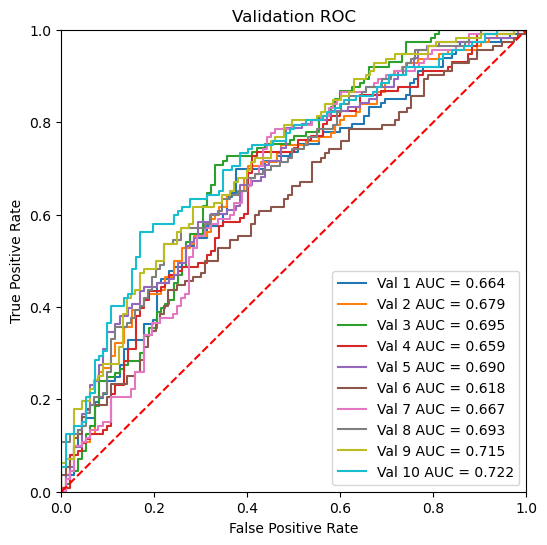

In [56]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

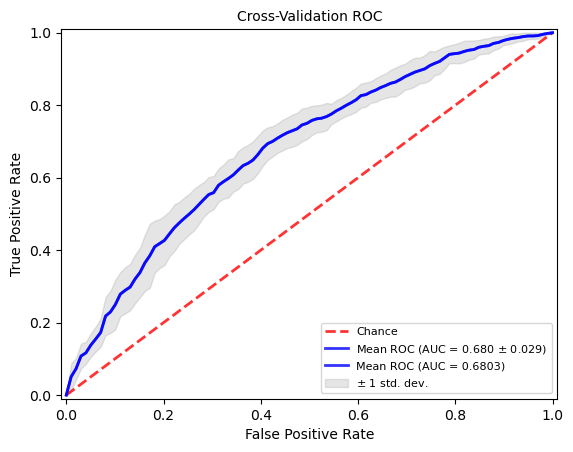

In [57]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [58]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [59]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [60]:
my_calculate_metrics_list_val

[{'SN': 0.7699115044247787,
  'SP': 0.44642857142857145,
  'ACC': 0.6088888888888889,
  'MCC': 0.22871006660805795,
  'Recall': 0.7699115044247787,
  'Precision': 0.5838926174496645,
  'F1-score': 0.6641221374045801,
  'Cutoff': 0.5},
 {'SN': 0.5357142857142857,
  'SP': 0.7232142857142857,
  'ACC': 0.6294642857142857,
  'MCC': 0.26360368751853647,
  'Recall': 0.5357142857142857,
  'Precision': 0.6593406593406593,
  'F1-score': 0.5911330049261084,
  'Cutoff': 0.5},
 {'SN': 0.7787610619469026,
  'SP': 0.4642857142857143,
  'ACC': 0.6222222222222222,
  'MCC': 0.25613084233832545,
  'Recall': 0.7787610619469026,
  'Precision': 0.5945945945945946,
  'F1-score': 0.6743295019157088,
  'Cutoff': 0.5},
 {'SN': 0.6017699115044248,
  'SP': 0.5982142857142857,
  'ACC': 0.6,
  'MCC': 0.1999841972187105,
  'Recall': 0.6017699115044248,
  'Precision': 0.6017699115044248,
  'F1-score': 0.6017699115044248,
  'Cutoff': 0.5},
 {'SN': 0.7345132743362832,
  'SP': 0.5267857142857143,
  'ACC': 0.631111111111

In [61]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.769912,0.446429,0.608889,0.228710,0.769912,0.583893,0.664122,0.5
1,0.535714,0.723214,0.629464,0.263604,0.535714,0.659341,0.591133,0.5
2,0.778761,0.464286,0.622222,0.256131,0.778761,0.594595,0.674330,0.5
3,0.601770,0.598214,0.600000,0.199984,0.601770,0.601770,0.601770,0.5
4,0.734513,0.526786,0.631111,0.267191,0.734513,0.610294,0.666667,0.5
5,0.437500,0.761062,0.600000,0.209915,0.437500,0.644737,0.521277,0.5
6,0.625000,0.628319,0.626667,0.253319,0.625000,0.625000,0.625000,0.5
7,0.723214,0.504425,0.613333,0.233235,0.723214,0.591241,0.650602,0.5
8,0.741071,0.548673,0.644444,0.295182,0.741071,0.619403,0.674797,0.5
9,0.750000,0.562500,0.656250,0.318142,0.750000,0.631579,0.685714,0.5


In [62]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.769912,0.446429,0.608889,0.228710,0.769912,0.583893,0.664122,0.5
1,0.535714,0.723214,0.629464,0.263604,0.535714,0.659341,0.591133,0.5
2,0.778761,0.464286,0.622222,0.256131,0.778761,0.594595,0.674330,0.5
3,0.601770,0.598214,0.600000,0.199984,0.601770,0.601770,0.601770,0.5
4,0.734513,0.526786,0.631111,0.267191,0.734513,0.610294,0.666667,0.5
5,0.437500,0.761062,0.600000,0.209915,0.437500,0.644737,0.521277,0.5
6,0.625000,0.628319,0.626667,0.253319,0.625000,0.625000,0.625000,0.5
7,0.723214,0.504425,0.613333,0.233235,0.723214,0.591241,0.650602,0.5
8,0.741071,0.548673,0.644444,0.295182,0.741071,0.619403,0.674797,0.5
9,0.750000,0.562500,0.656250,0.318142,0.750000,0.631579,0.685714,0.5


In [63]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [64]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [65]:
roc_auc_list_indep

[0.6825573979591837,
 0.6758609693877551,
 0.6604751275510204,
 0.6857461734693877,
 0.6710778061224489,
 0.6698820153061223,
 0.6792091836734694,
 0.6667729591836736,
 0.6698022959183674,
 0.6435746173469388]

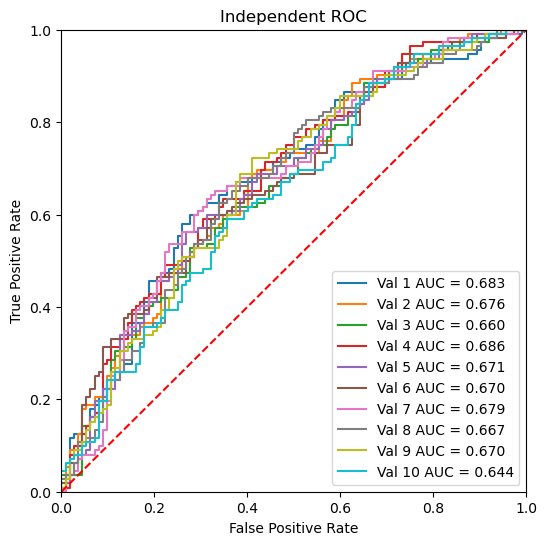

In [66]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

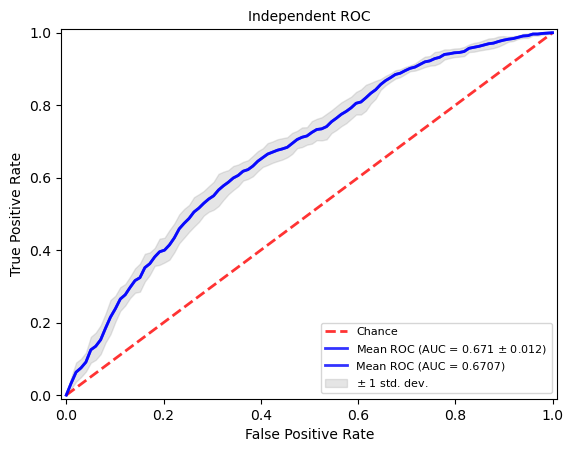

In [67]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [68]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [69]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [70]:
my_calculate_metrics_list_indep

[{'SN': 0.75,
  'SP': 0.4732142857142857,
  'ACC': 0.6116071428571429,
  'MCC': 0.23228944722419187,
  'Recall': 0.75,
  'Precision': 0.5874125874125874,
  'F1-score': 0.6588235294117647,
  'Cutoff': 0.5},
 {'SN': 0.5357142857142857,
  'SP': 0.6964285714285714,
  'ACC': 0.6160714285714286,
  'MCC': 0.2352002315818805,
  'Recall': 0.5357142857142857,
  'Precision': 0.6382978723404256,
  'F1-score': 0.5825242718446602,
  'Cutoff': 0.5},
 {'SN': 0.7589285714285714,
  'SP': 0.42857142857142855,
  'ACC': 0.59375,
  'MCC': 0.19865318333296889,
  'Recall': 0.7589285714285714,
  'Precision': 0.5704697986577181,
  'F1-score': 0.6513409961685823,
  'Cutoff': 0.5},
 {'SN': 0.5892857142857143,
  'SP': 0.6785714285714286,
  'ACC': 0.6339285714285714,
  'MCC': 0.26893123948667963,
  'Recall': 0.5892857142857143,
  'Precision': 0.6470588235294118,
  'F1-score': 0.616822429906542,
  'Cutoff': 0.5},
 {'SN': 0.7053571428571429,
  'SP': 0.5,
  'ACC': 0.6026785714285714,
  'MCC': 0.20982921140985644,
  'R

In [71]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.750000,0.473214,0.611607,0.232289,0.750000,0.587413,0.658824,0.5
1,0.535714,0.696429,0.616071,0.235200,0.535714,0.638298,0.582524,0.5
2,0.758929,0.428571,0.593750,0.198653,0.758929,0.570470,0.651341,0.5
3,0.589286,0.678571,0.633929,0.268931,0.589286,0.647059,0.616822,0.5
4,0.705357,0.500000,0.602679,0.209829,0.705357,0.585185,0.639676,0.5
5,0.553571,0.687500,0.620536,0.243263,0.553571,0.639175,0.593301,0.5
6,0.642857,0.669643,0.656250,0.312612,0.642857,0.660550,0.651584,0.5
7,0.776786,0.491071,0.633929,0.279508,0.776786,0.604167,0.679688,0.5
8,0.696429,0.589286,0.642857,0.287368,0.696429,0.629032,0.661017,0.5
9,0.651786,0.526786,0.589286,0.179983,0.651786,0.579365,0.613445,0.5


In [72]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.750000,0.473214,0.611607,0.232289,0.750000,0.587413,0.658824,0.5
1,0.535714,0.696429,0.616071,0.235200,0.535714,0.638298,0.582524,0.5
2,0.758929,0.428571,0.593750,0.198653,0.758929,0.570470,0.651341,0.5
3,0.589286,0.678571,0.633929,0.268931,0.589286,0.647059,0.616822,0.5
4,0.705357,0.500000,0.602679,0.209829,0.705357,0.585185,0.639676,0.5
5,0.553571,0.687500,0.620536,0.243263,0.553571,0.639175,0.593301,0.5
6,0.642857,0.669643,0.656250,0.312612,0.642857,0.660550,0.651584,0.5
7,0.776786,0.491071,0.633929,0.279508,0.776786,0.604167,0.679688,0.5
8,0.696429,0.589286,0.642857,0.287368,0.696429,0.629032,0.661017,0.5
9,0.651786,0.526786,0.589286,0.179983,0.651786,0.579365,0.613445,0.5


In [73]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_2\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

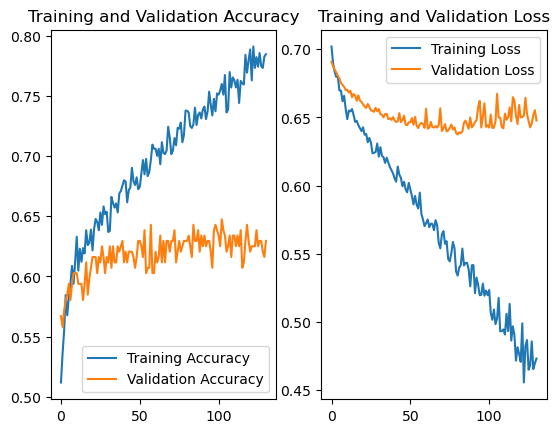

In [75]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()